In [1]:
from keras.datasets import fashion_mnist
import wandb
wandb.login()

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

wandb: Currently logged in as: gsathish333. Use `wandb login --relogin` to force relogin


In [2]:
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [3]:
def pre_process(x):
    x=x.reshape(-1,784)
    x=x/255
    return x

In [4]:
x_train=pre_process(x_train)
x_test=pre_process(x_test)

In [5]:
def sigmoid(x):
    return 1.0/(1+np.exp(-x))
def sigmoidPrime(x):
    return sigmoid(x)*(1-sigmoid(x))


def relu(x):
    return x if x>0 else 0

def reluPrime(x):
    return 1 if x>0 else 0

In [6]:
def soft_max(x):
    return np.exp(x)/np.sum(np.exp(x),axis=0)

In [7]:
def soft_max_prime(x):
    return soft_max(x)*(1-soft_max(x))
    

In [8]:
class OneHotEncoder:
    def __init__(self,max_):
        self.max_=max_
    def transform(self,x):
        out=np.zeros((len(x),self.max_))
        out[np.arange(len(x)),x]=1
        return out.T

In [31]:
def cross_entropy_loss(y_pre,y):
    loss=-np.sum(y*np.log(y_pre))
    return loss/float(y_pre.shape[1])

In [32]:
def getSig():
    return lambda x:1.0/(1+np.exp(-x))

In [33]:
batch_size=2048

In [34]:
class NN:
    def __init__(self,input_size,layers,activations):
        self.input_size=input_size
        self.layers=layers
        self.nlayers=len(layers)
        self.weights=[]
        self.weights.append(np.random.randn(layers[0],input_size))
        self.deltas=[None]*self.nlayers
        self.gradients=[None]*self.nlayers
        self.biases=[]
        for i in range(1,len(layers)):
            self.weights.append(np.random.randn(layers[i],layers[i-1]))
        for i in range(len(layers)):
            self.biases.append(np.random.randn(layers[i],1))                              
    def forward(self,x):
        layer_outputs=[]
        inter_values=[]
        
        for i in range(len(self.weights)):
            inter_values.append(self.weights[i].dot(x)+self.biases[i])
#             sig=getSig()
            if i!= len(self.weights)-1:
                layer_outputs.append(sigmoid(inter_values[-1]))
                x=layer_outputs[-1]
        layer_outputs.append(soft_max(inter_values[-1]))
        return layer_outputs,inter_values
    def compute_deltas(self,layer_outputs,inter_values,y_one_hot):
        self.deltas[self.nlayers-1]=(layer_outputs[self.nlayers-1]-y_one_hot)*soft_max_prime(inter_values[self.nlayers-1])
        
        for i in range(self.nlayers-2,-1,-1):
            self.deltas[i]=np.matmul(self.weights[i+1].T,self.deltas[i+1])*sigmoidPrime(inter_values[i])
        
    def find_gradients(self,x,layer_outs):
        self.gradients[0]=np.matmul(self.deltas[0],x.T)/batch_size
        for i in range(1,self.nlayers):
            self.gradients[i]=(np.dot(self.deltas[i],layer_outs[i-1].T))/batch_size
            
    def update_weights(self,lr):
        for each in range(self.nlayers):
            self.weights[each]=self.weights[each]-lr*self.gradients[each]
            
    def train(self,x,y,epochs=1):
        losses=[]
        for epoch in range(epochs):    
            i=0
            batch_count=0
            loss=0
            while i+batch_size < x.shape[1]:
                batch_count+=1
                x_batch=x[:,i:i+batch_size]
                y_batch=y[:,i:i+batch_size]
                i+=512
                layer_outs,inter_values=self.forward(x_batch)
                loss+=cross_entropy_loss(layer_outs[-1],y_batch)
                self.compute_deltas(layer_outs,inter_values,y_batch)
                self.find_gradients(x_batch,layer_outs)
                self.update_weights(lr=0.1)
            losses.append(loss/batch_count)
            print(f"epoch {epoch+1} : loss = {loss/batch_count}")
        return losses
    
    def predict_probas(self,x):
        layer_outs,inter_values=self.forward(x)
        return layer_outs[-1]
        

In [35]:
sample=60000
x_tr=x_train[:sample]

y_tr=y_train[:sample]

one_hot=OneHotEncoder(10)
one_hot_y=one_hot.transform(y_tr)


In [36]:
obj =NN(784,[128,128,128,10],'sigmoid')
losses=obj.train(x_tr.T,one_hot_y,10)

epoch 1 : loss = 5.1273753299383635
epoch 2 : loss = 3.092348874947717
epoch 3 : loss = 2.471577661569845
epoch 4 : loss = 2.1520124626372423
epoch 5 : loss = 1.9381951339571433
epoch 6 : loss = 1.7824885019541976
epoch 7 : loss = 1.6578003922956985
epoch 8 : loss = 1.552306754214337
epoch 9 : loss = 1.4616353359804588
epoch 10 : loss = 1.3833497515702315


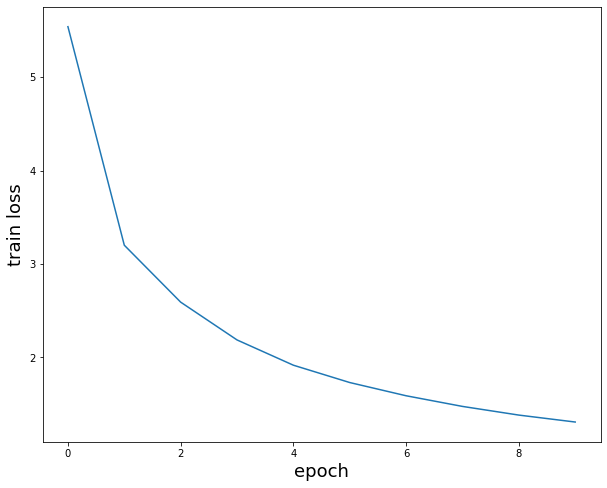

In [15]:

plt.figure(figsize=(10,8))
plt.plot(losses)
plt.xlabel("epoch",fontsize=18)
plt.ylabel("train loss",fontsize=18)
plt.show()

In [16]:
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="Assignment_1_Q3",
    
#     # track hyperparameters and run metadata
#     config={
#     "dataset": "Fashion Mnist",
#     }
# )

# for loss in losses:
#     wandb.log({'loss':loss})

In [17]:
out=obj.predict_probas(x_tr.T)
pred=np.argmax(out,axis=0)
print(classification_report(pred,y_train.flatten()))

              precision    recall  f1-score   support

           0       0.65      0.61      0.63      6421
           1       0.84      0.84      0.84      5977
           2       0.47      0.47      0.47      6000
           3       0.62      0.62      0.62      6048
           4       0.61      0.46      0.52      7982
           5       0.45      0.57      0.50      4781
           6       0.12      0.28      0.17      2618
           7       0.75      0.70      0.72      6508
           8       0.68      0.61      0.64      6662
           9       0.78      0.67      0.72      7003

    accuracy                           0.60     60000
   macro avg       0.60      0.58      0.58     60000
weighted avg       0.63      0.60      0.61     60000



In [18]:
out=obj.predict_probas(x_test.T)
pred=np.argmax(out,axis=0)
print(classification_report(pred,y_test.flatten()))

              precision    recall  f1-score   support

           0       0.65      0.59      0.62      1104
           1       0.83      0.86      0.84       971
           2       0.44      0.43      0.44      1022
           3       0.60      0.61      0.60       978
           4       0.57      0.44      0.49      1304
           5       0.46      0.57      0.51       798
           6       0.10      0.22      0.14       464
           7       0.77      0.70      0.74      1096
           8       0.68      0.61      0.64      1103
           9       0.78      0.67      0.72      1160

    accuracy                           0.59     10000
   macro avg       0.59      0.57      0.57     10000
weighted avg       0.62      0.59      0.60     10000

